In [7]:
import cv2
import os
import matplotlib.pyplot as plt
import json
import tensorflow as tf
import numpy as np

from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log
import perception
import warnings
warnings.filterwarnings("ignore")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)
tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print(tf.config.list_physical_devices())

1 Physical GPUs, 1 Logical GPUs
Num GPUs Available:  1
Num CPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [9]:
config = perception.CocoConfig()
class_names = ['BG', 'person', 'rider', 'car', 'bus', 'truck', 'bike', 'motor', 'traffic light', 'traffic sign', 'train']

In [10]:
image_dir = "/run/media/sam/Dataset/bdd100k-models/data/bdd100k/images/100k/test/"
coco_dir = "/home/sam/Desktop/cocoData/"
output_image_path = "/home/sam/Desktop/output/"
weights_path = "/home/sam/Documents/GitHub/honoursProject/PedestrianDetection/object_detection/training_log_rgb/coco20190811T1837/mask_rcnn_coco_0005.h5"
MODEL_DIR = "/home/sam/Documents/GitHub/honoursProject/PedestrianDetection/object_detection/training_log_rgb"

In [11]:
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(
    weights_path , by_name=True,
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask", "rpn_model"])

Re-starting from epoch 5


In [12]:
def get_image_list(image_dir):
    files= os.listdir(image_dir) 
    s = []
    for file in files: 
        str_name = file[:21]
        s.append(str_name) 
    return s

image_list = get_image_list(image_dir)

In [13]:
def get_individual_class_details(class_ids, scores, rois):
    
    result_array = dict()
    for index in range(len(class_ids)):

        predicted_class = class_names[class_ids[index]]
        predicted_class_score = scores[index].tolist()
        predicted_class_boxes = rois[index].tolist()

        result_array[predicted_class] = ({"Confidence":[predicted_class_score]}, 
                                                 {"Bounding box":[predicted_class_boxes]})

    #print(result_array)
    return result_array

/run/media/sam/Dataset/bdd100k-models/data/bdd100k/images/100k/test/e4206341-c7828824.jpg
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000  float64
image_metas              shape: (1, 23)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


2022-02-21 18:21:33.046236: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -52 } dim { size: 256 } dim { size: 256 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -19 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -19 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 7 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory

/run/media/sam/Dataset/bdd100k-models/data/bdd100k/images/100k/test/cabc30fc-e7726578.jpg
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000  float64
image_metas              shape: (1, 23)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
/run/media/sam/Dataset/bdd100k-models/data/bdd100k/images/100k/test/cabc30fc-eb673c5a.jpg
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000  float64
image_metas              shape: (1, 23)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


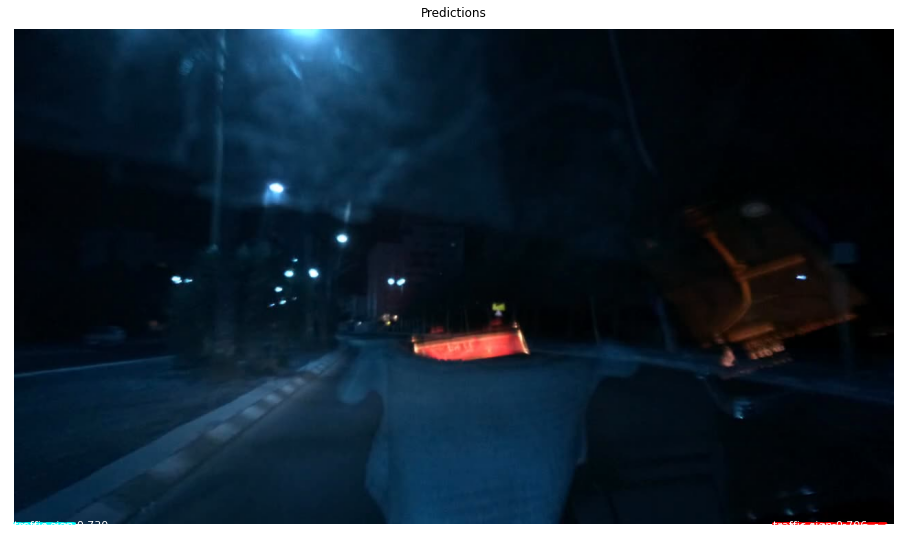

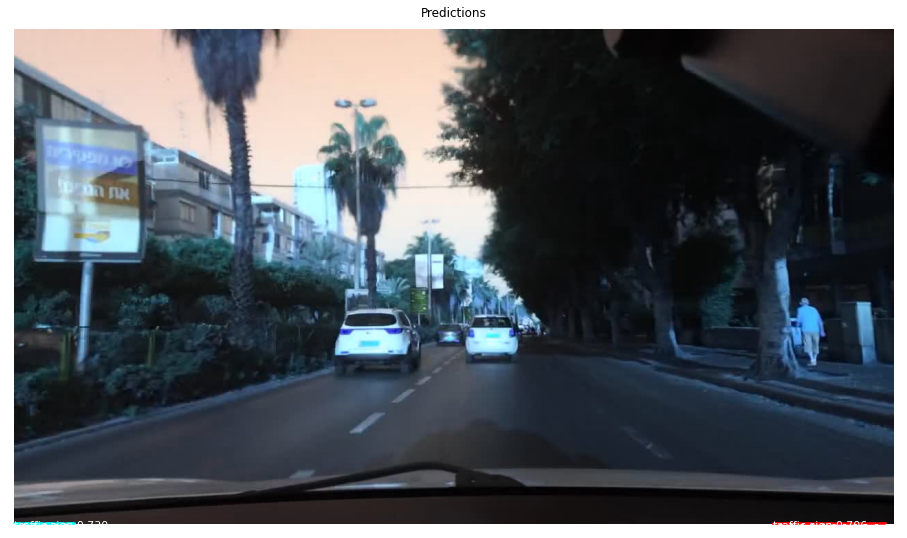

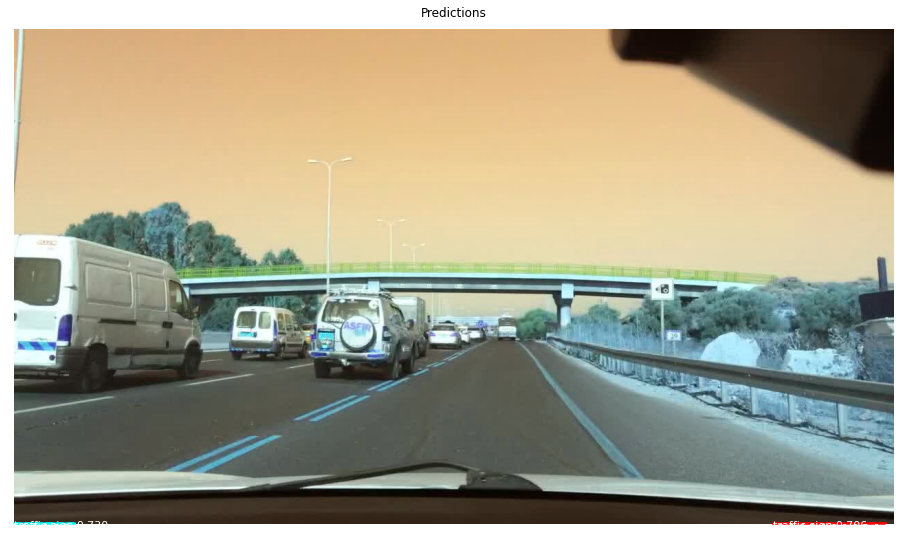

In [14]:
test_annos = dict()
JSON_PATH_OUTPUT = os.path.join(output_image_path, "results.json")
for i in range(len(image_list)):
    image_path = os.path.join(image_dir,image_list[i]) 
    print(image_path)
    image = cv2.imread(image_path)

    height, width = image.shape[:2]

    results = model.detect([image], verbose=1)


    r = results[0]
    image_ir = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'], 
                                title="Predictions")
    plt.savefig(os.path.join(output_image_path,image_list[i]), bbox_inches='tight')
     
    class_details = get_individual_class_details(r['class_ids'], r['scores'], r['rois'])
    test_annos[i] = ({image_list[i] : class_details})
    
    #test_annos[image_list[i]] = (get_individual_class_details(r['class_ids'], r['scores'], r['rois']))
        
    if i==2:
        break
        
test_annos = {"Mask R-CNN with ResNet101 backbone and Feature Pyramid Network (FPN)": test_annos}
#print(test_annos)
fd = open(JSON_PATH_OUTPUT, 'w')
json.dump(test_annos,fd,indent=4,sort_keys=True)

fd.close()